In [3]:
%load_ext autoreload
%autoreload 2
import tensorflow as tf
import numpy as np
import pandas as pd
#import librosa
import logging
import os
from scipy.io import wavfile

#os.environ["KMP_DUPLICATE_LIB_OK"]="TRUE"
# Configure the logging settings
logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(name)s - %(levelname)s - %(message)s')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [21]:
import numpy as np
import librosa
import librosa.display
import matplotlib.pyplot as plt

def audio_to_mel_spectrogram(audio_file_path, max_length=4*22500, sr=22500, n_mels=256):
    # Load the audio file
    y, sr = librosa.load(audio_file_path, sr=sr)
    
    if len(y) > max_length:
        # If the audio is longer than the maximum length, cut it
        y = y[:max_length]
    elif len(y) < max_length:
        # If the audio is shorter, pad it with zeros
        pad_length = max_length - len(y)
        y = np.pad(y, (0, pad_length), mode='constant')
    
    # Calculate the Mel spectrogram
    mel_spectrogram = librosa.feature.melspectrogram(y=y, sr=sr, n_fft=n_mels)
    mel_spectrogram = librosa.power_to_db(mel_spectrogram, ref=np.max)
    
    return mel_spectrogram


(128, 176)
(128, 176)
(128, 176)


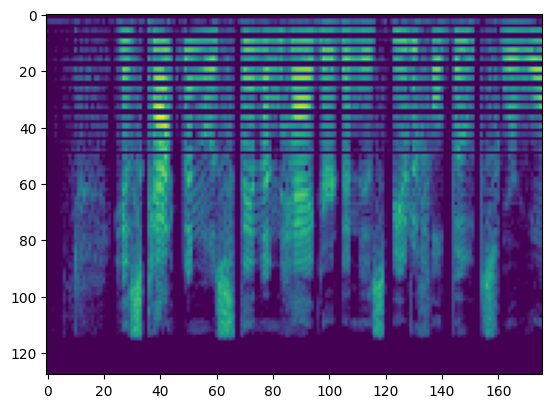

In [20]:
for audio_file in audio_files[:3]:
    print(audio_to_mel_spectrogram(audio_file).shape)
    plt.imshow(audio_to_mel_spectrogram(audio_file))


In [22]:
# Generator function for lazy loading of audio data
def audio_data_generator(audio_files):
    for audio_file in audio_files:
        yield audio_to_mel_spectrogram(audio_file)

# Load a list of audio files
audio_files_df = pd.read_csv('data_files_summary.csv')
audio_files = audio_files_df['full_path'].to_list()

In [ ]:
%%time
# Create a generator to load and preprocess audio data on-the-fly
data_generator = audio_data_generator(audio_files)
data_iterator = iter(data_generator)  # Convert the generator to an iterator

# To train an autoencoder, you need target data, which is the same as the input data
# So, use the same data for both input and target
X_train = np.array(list(data_iterator))
X_train.shape

In [ ]:
X_train = X_train.reshape(6300, 128, 176, 1)

In [ ]:
X_train_scaled = ((X_train + 80)/80)
X_train_scaled.min(), X_train_scaled.max()

In [ ]:
import tensorflow as tf
from tensorflow.keras.layers import Input, Conv2D, Conv2DTranspose, MaxPooling2D, UpSampling2D, Normalization, Reshape, Dense, Flatten, Cropping2D
from tensorflow.keras.models import Model

# Define the input shape
input_shape = (128, 176, 1)  # You can adjust the input shape based on your data

# Define the encoder
input_layer = Input(shape=input_shape)
x = input_layer

x = Conv2D(128, kernel_size = (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(32, (3, 3), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
x = Conv2D(8, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = MaxPooling2D((2, 2), padding='same')(x)
encoded = x

x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(32, (3, 3), strides=(2, 2), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
x = Conv2DTranspose(128, (3, 3), activation='relu', padding='same')(x)
x = UpSampling2D((2, 2))(x)
#x = Cropping2D(cropping=((3, 0), (0, 0)))(x)
decoded = Conv2D(1, (3, 3), activation='sigmoid', padding='same')(x)

autoencoder = Model(input_layer, decoded)

# Compile the autoencoder
autoencoder.compile(optimizer='adam', loss='mse')
# Print the model summary
autoencoder.summary()

In [ ]:
from tensorflow.keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='loss', patience=2, verbose=1, restore_best_weights=True)
# Step 3: Train the autoencoder using audio data
logging.info('Training the autoencoder...')
autoencoder.fit(X_train_scaled, X_train_scaled, batch_size=64, epochs=50, callbacks=[early_stopping])
logging.info('Training complete.')

In [53]:
autoencoder.save('autoencoder_model')

INFO:tensorflow:Assets written to: autoencoder_model\assets


2023-10-20 12:45:31,460 - tensorflow - INFO - Assets written to: autoencoder_model\assets


In [54]:
import soundfile as sf  # Soundfile library for saving the WAV file
def spectrogram_to_audio(spectrogram, sr=22500, max_length=4*22500):
    # Inverse operation to recover the magnitude spectrum
    magnitude = librosa.db_to_amplitude(spectrogram)#, ref=np.max)
    # Inverse Short-Time Fourier Transform (iSTFT) to obtain the time-domain signal
    y_reconstructed = librosa.istft(magnitude)
    return y_reconstructed

# Example usage
spectrogram = audio_to_spectrogram("converted.wav", sr=48000).reshape((1, 1025, 176, 1))
spectrogram = (spectrogram+80)/80
out_spectre = autoencoder.predict(spectrogram)
out_spectre = (out_spectre*80)-80
out_spectre = out_spectre.reshape((1025, 176))
reconstructed_audio = spectrogram_to_audio(out_spectre, 48000) * 1e3
sf.write("reconstructed_audio.wav", np.ravel(reconstructed_audio), 48000)  # Adjust the sample rate as needed


1/1 [==============================] - 0s 185ms/step


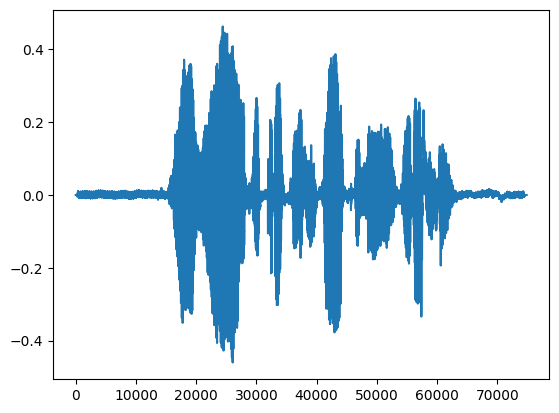

In [55]:
y, sr = librosa.load('converted.wav', sr=22500, duration=112500)
plt.plot(y)

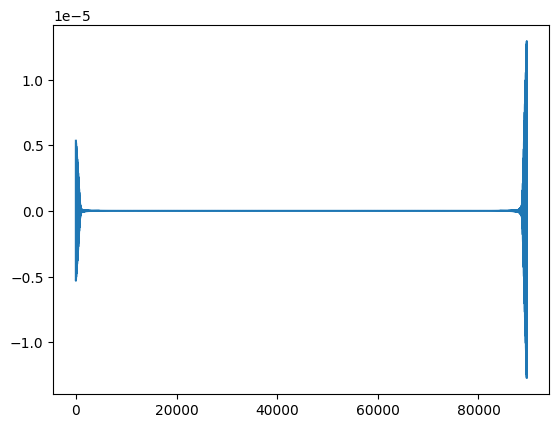

In [56]:
plt.plot(reconstructed_audio)

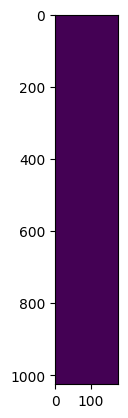

In [57]:
plt.imshow(out_spectre)

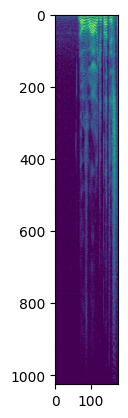

In [58]:
plt.imshow(spectrogram[0])